In [1]:
import tensorflow as tf
import numpy as np
from __future__ import division
import time
from time import gmtime, strftime
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

import os
from os import listdir
from os.path import isfile, join

from utils import *
%matplotlib inline 

In [2]:
# Functions for making tensorflow graph objects for each layer
def add_layer(namescope, inputs, in_size, out_size, activation_function=None):
    inputs = tf.cast(inputs, tf.float32)
    with tf.name_scope(namescope):
        #w = tf.random_normal([in_size, out_size], mean=0, stddev=0.000001)
        w = tf.zeros([in_size, out_size])
        Weights = tf.Variable(w, dtype=tf.float32, name='weights')
        biases = tf.Variable(tf.zeros([out_size]), dtype=tf.float32, name='biases')
        Wx_plus_b = tf.matmul(inputs , Weights)+biases
        if activation_function is None :
            output = Wx_plus_b
        else:
            output = activation_function(Wx_plus_b)
            
    return output   


# Define Agent 
class agent():
    def __init__(self, lr, dims):
        # lr is learning rate
        # dims is a list of dimensions of each layer [dimension_of_input, dim_of_hiddenlayer1, ... dim_of_hiddenlayerN, dim_of_output]
        in_dim = dims[0]
        out_dim = dims[-1]
        
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        with tf.name_scope("Input"):
            self.input_layer = tf.placeholder(dtype = tf.float32, shape=[None, in_dim], name = 'state')
        
        # make hidden layers only if specified in dims list
        if len(dims)>2:
            hidden_layers = []
            for i in range(len(dims)-2):
                layername = "H_"+str(i+1)
                if i == 0:
                    hiddenlayer = add_layer(layername, self.input_layer, dims[i], dims[i+1], activation_function=tf.nn.sigmoid)
                else:
                    hiddenlayer = add_layer(layername, hidden_layers[-1], dims[i], dims[i+1], activation_function=tf.nn.sigmoid)
                hidden_layers.append(hiddenlayer)

            self.policy = add_layer("Policy", hidden_layers[-1], dims[-2], out_dim, activation_function = tf.nn.softmax)
            self.value  = add_layer("Value", hidden_layers[-1], dims[-2], 1, activation_function=None)
        # if dims only has input/output dimension, connect output layer directly to input
        # using this right now for testing
        else:
            self.policy = add_layer("Policy", self.input_layer, in_dim, out_dim, activation_function = tf.nn.softmax)
            self.value  = add_layer("Value", self.input_layer, in_dim, 1, activation_function=None)
        
        
        # make variable lists to specify to tensorflow which variables to update with which gradients
        self.policy_vars = tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope="Layer1")+tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope="Layer2")+tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope="Policy")
        self.value_vars = tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope="Layer1")+tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope="Layer2")+tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope="Value")
        #list of all variables, not used -- may take out later
        self.tvars = tf.trainable_variables()
        
        #The next six lines establish the training proceedure. We feed the return and chosen action into the network
        #to compute the loss, and use it to update the network.
        with tf.name_scope("Loss"):
            self.return_holder = tf.placeholder(shape=[None],dtype=tf.float32)
            self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)

            self.indexes = tf.range(0, tf.shape(self.policy)[0]) * tf.shape(self.policy)[1] + self.action_holder
            self.responsible_outputs = tf.gather(tf.reshape(self.policy, [-1]), self.indexes)
            # calculate reward prediction errors
            self.rpe = self.return_holder - self.value
            
            self.actor_loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.rpe)
            self.critic_loss = 0.5 * tf.reduce_mean(tf.square(self.rpe))

        with tf.name_scope("Training"):
            # make placeholders to store gradients -- maybe a clunky way to do this but will become useful later
            # rather than feeding gradients directly to the apply gradients operation
            self.p_gradient_holders = []
            self.v_gradient_holders = []
            for idx,var in enumerate(self.policy_vars):
                placeholder = tf.placeholder(tf.float32,name=str(idx)+'_p_holder')
                self.p_gradient_holders.append(placeholder)

            for idx,var in enumerate(self.value_vars):
                placeholder = tf.placeholder(tf.float32,name=str(idx)+'_v_holder')
                self.v_gradient_holders.append(placeholder)
            
            # specifiy which training we are going to do for policy
            pol_trainer = tf.train.GradientDescentOptimizer(learning_rate=lr)
            
            # calculate gradients for policy loss only on policy variables
            self.get_pol_grads = tf.gradients(self.actor_loss, self.policy_vars)
            # op for updating policy gradients
            self.update_pol = pol_trainer.apply_gradients(zip(self.p_gradient_holders, self.policy_vars))
            
            # specifiy which training we are going to do for value
            val_trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001*lr)
            # calulate gradients for value loss
            self.get_val_grads = tf.gradients(self.critic_loss, self.value_vars)
            # op for updating value gradients
            self.update_val = val_trainer.apply_gradients(zip(self.v_gradient_holders, self.value_vars)) 

In [20]:
#========================
# Environment Parameters
#======================== 
height = 10
width = 10

mazetype = 'none'
#obstacle density
obs_rho = 0

#place cells
place_cells = 700
#place cell full width half max (must be <1)
fwhm = 0.2

#make environment
maze = gridworld([height, width],rho=obs_rho,num_pc=place_cells, pc_fwhm=fwhm, maze_type=mazetype)

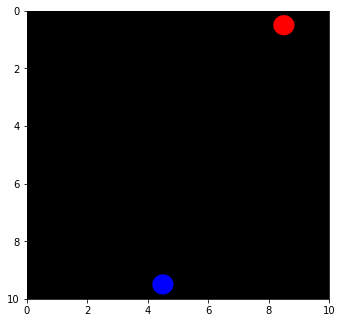

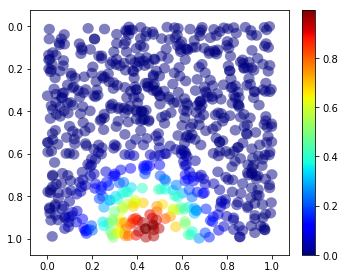

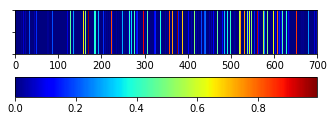

In [21]:
#========================
# Environment Plots
#======================== 

# plot maze -- agent (blue) and reward (red)
plt.figure()
fig = plt.figure()
axis  = fig.add_axes([0, 0, .7, 1]) # [left, bottom, width, height]

grid = maze.grid
useable_grid = maze.useable
rwd_loc = maze.rwd_loc
agent_loc = maze.cur_state


ax = fig.gca()
axis.pcolor(grid, cmap = 'bone', vmax =1, vmin = 0)

rwd_v, rwd_h = rwd_loc

agent_v, agent_h = agent_loc

ax.add_patch(plt.Circle((rwd_v+.5, rwd_h+.5), 0.35, fc='r'))
ax.add_patch(plt.Circle((agent_v+.5, agent_h+.5), 0.35, fc='b'))

ax.invert_yaxis()
#plt.colorbar()
plt.axis('tight')

#plot_grid(maze)


# plot place cells 
# circle radius given by fwhm of place cells (???)
fig = plt.figure()
ax  = fig.add_axes([0, 0.1, 0.6, 0.85]) # [left, bottom, width, height]
axc = fig.add_axes([0.63, 0.1, 0.03, 0.85])

cmap = plt.cm.jet
cNorm  = colors.Normalize(vmin=0, vmax=max(maze.pcs.activity(maze.cur_state)))
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap=cmap)

for i in range(len(maze.pcs.x)):
    colorVal = scalarMap.to_rgba(maze.pcs.activity(maze.cur_state)[i])
    ax.add_patch(patches.Circle((maze.pcs.x[i], maze.pcs.y[i]), 0.025, fc=colorVal, ec='none', alpha=0.5))
    ax.set_ylim([1,0])
cb1 = mpl.colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)
ax.axis('equal')
ax.axis('tight')

# plot input vector
fig = plt.figure()
ax  = fig.add_axes([0, 0.25, 0.7, 0.15]) # [left, bottom, width, height]
axc = fig.add_axes([0, 0.1, 0.7, 0.07])

ax.pcolor(maze.pcs.activity(maze.cur_state).reshape(1,maze.pcs.activity(maze.cur_state).shape[0]), vmin=0, vmax=1, cmap='jet')
ax.set_yticklabels([''])
cb2 = mpl.colorbar.ColorbarBase(axc, cmap = cmap, norm = cNorm, orientation='horizontal')

In [31]:
#=====================
# Training Parameters
#=====================
#trial parameters
NUM_TRIALS = 10000

NUM_EVENTS = 300
SAMPLE_TRIAL = NUM_TRIALS-1

discount_factor = 0.98
port_shift = 'none'


#gradient descent learning rate
eta = 1e-3

In [32]:
saveplots = False

if mazetype=='none':
    pathvar = './valplots/grid/{}/'.format(obs_rho)
    figpath = './figures/grid/{}/'.format(obs_rho)
else: 
    pathvar = './valplots/{}/'.format(mazetype)
    figpath = './figures/{}/'.format(mazetype)

if not os.path.exists(figpath):
    os.makedirs(figpath)
if saveplots:
    if not os.path.exists(pathvar):
        os.makedirs(pathvar)

In [33]:
# Single run of NUM_TRIALS each with NUM_EVENTS
tf.reset_default_graph()

dims = [len(maze.net_state[0]),50,len(maze.actionlist)]

myAgent = agent(lr=eta, dims=dims)
#tf.summary.FileWriter('./outputs/maze3/', graph=tf.get_default_graph())

print_freq = 1./10
init = tf.global_variables_initializer()


with tf.Session() as sess:
    steps_rwd = []
    
    sess.run(init)
    
    pGrad_buf = sess.run(myAgent.policy_vars)
    vGrad_buf = sess.run(myAgent.value_vars)
    
    total_reward = []
    trialtime = []
    total_loss = [[],[]]

    blocktime = time.time()
    val_maps = []
    
    p_field = np.zeros((height, width), dtype=[('action_taken', 'i4'),('taken_prob', 'f4'), ('likely_action', 'i4'),('likely_prob', 'f4'), ('timestep', 'i4')])
    
    print strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime())
    for i in xrange(NUM_TRIALS):
        start_time = time.time()

        _ep_buffer = []
        reward_sum = 0

        # reset gradient buffers
        for ix,grad in enumerate(pGrad_buf):
            pGrad_buf[ix] = grad * 0
        for ix,grad in enumerate(vGrad_buf):
            vGrad_buf[ix] = grad * 0

        # reset the environment
        maze.start_trial()
        maze.value_map = maze.init_value_map
        
        state = maze.net_state
        
        for j in xrange(NUM_EVENTS): 
            # get policy and value estimate in order to select next action
            tfprob_, val_ = sess.run([myAgent.policy, myAgent.value], feed_dict={myAgent.input_layer:state})

            # process tensorflow lists to get right shape
            tfprob = tfprob_[0]
            val = val_[0][0]
            #print maze.cur_state, val, "###"
            maze.value_map[maze.cur_state[1]][maze.cur_state[0]] = val

            # select action
            choice = np.random.choice(np.arange(len(tfprob)), 1, p=tfprob)[0]
            action = maze.actionlist[choice]


            p_field[maze.cur_state[1]][maze.cur_state[0]] = (choice, list(tfprob)[choice], list(tfprob).index(max(list(tfprob))), max(list(tfprob)), i)
            
            # get new state of the environment and reward from action 
            if j < NUM_EVENTS:
                next_state = maze.move(action)

            rwd = maze.rwd

            # store buffer of agents experiences so that later we can calulate returns/etc. backwards through time
            _ep_buffer.append([state,choice,rwd,next_state, val])

            # update state
            state = next_state

            reward_sum += rwd
            
            #if maze.done == True: 
            #    trialtime.append(j)
            #    break
            #elif j == NUM_EVENTS-1:
            #    trialtime.append(NUM_EVENTS)
        # make data storage useable type 
        _ep_buffer = np.array(_ep_buffer)
        # compute returns
        _returns = discount_rwds(_ep_buffer[:,2], gamma=discount_factor)

        feed_dict = {myAgent.return_holder:_returns, myAgent.action_holder:_ep_buffer[:,1], myAgent.input_layer:np.vstack(_ep_buffer[:,0])}

        # calculate gradients using the information stored in the episode buffer
        # computed returns (backward through time)
        # which actions were taken gives which policy unit was responsible (so grads are computed properly)
        # pass states agent was in at each timestep through the network again to recompute the value and policy (for gradients computation in tf)
        a_loss, c_loss = sess.run([myAgent.actor_loss, myAgent.critic_loss], feed_dict=feed_dict)
        p_grads, v_grads = sess.run([myAgent.get_pol_grads, myAgent.get_val_grads], feed_dict=feed_dict)
        
        total_loss[0].append(a_loss)
        total_loss[1].append(c_loss)
        
        # store gradients in gradient buffers -- not necessary for the current formulation but will be more flexible for later
        # sorry for the additional complication 
        for idx, grad in enumerate(p_grads):
            pGrad_buf[idx] += grad

        for idx, grad in enumerate(v_grads):
            vGrad_buf[idx] += grad

        feed_dict = dict(zip(myAgent.p_gradient_holders, pGrad_buf)+zip(myAgent.v_gradient_holders, vGrad_buf))

        # run gradient update operations 
        _, __ = sess.run([myAgent.update_pol, myAgent.update_val], feed_dict = feed_dict)

        total_reward.append(reward_sum)
        val_maps.append(maze.value_map.copy())
        if saveplots:
            if (i%100 == 0):
                plt.clf()
                current_cmap = plt.cm.get_cmap()
                current_cmap.set_bad(color='white')
                plt.imshow(maze.value_map.copy(), vmin = 0, vmax=40, cmap = 'jet', interpolation='none')

                plt.annotate('*', np.add(maze.rwd_loc, (0, -0)), color='w')
                plt.title('{}'.format(i))
                #plt.gca().invert_yaxis()
                plt.colorbar()
                plt.savefig(pathvar+str(i),format='png')

        # print reward measure
        if i==1 or i%(print_freq*NUM_TRIALS)==0 or i == NUM_TRIALS-1: 
            print "Trial {0} finished in {1:.3f}. Total reward = {2} (Avg {3:.3f})".format(i, time.time()-start_time, reward_sum, float(reward_sum)/float(NUM_EVENTS)),
            print "Block took {0:.3f}".format(time.time()-blocktime)
            blocktime = time.time()


Mon, 27 Nov 2017 12:58:01 +0000
Trial 0 finished in 0.126. Total reward = 0 (Avg 0.000) Block took 0.126
Trial 1 finished in 0.116. Total reward = 0 (Avg 0.000) Block took 0.116
Trial 1000 finished in 0.114. Total reward = 0 (Avg 0.000) Block took 116.936
Trial 2000 finished in 0.115. Total reward = 5 (Avg 0.017) Block took 116.212
Trial 3000 finished in 0.115. Total reward = 16 (Avg 0.053) Block took 114.463
Trial 4000 finished in 0.113. Total reward = 21 (Avg 0.070) Block took 114.610
Trial 5000 finished in 0.115. Total reward = 37 (Avg 0.123) Block took 116.890
Trial 6000 finished in 0.121. Total reward = 16 (Avg 0.053) Block took 117.085


KeyboardInterrupt: 

In [12]:
def make_gif(mypath, mazetype):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    intfiles = [int(f) for f in onlyfiles]
    intfiles.sort()
    if mazetype =='none':
        gifname = './figures/gifs/grid{}.gif'.format(obs_rho)
    else: 
        gifname = './figures/gifs/{}.gif'.format(mazetype)
    

    with imageio.get_writer(gifname, mode='I', duration=0.5) as writer:
                for filename in intfiles:
                    image = imageio.imread(mypath+str(filename))
                    writer.append_data(image)
    print "Gif file saved at ", gifname

if saveplots:
    make_gif(pathvar, mazetype)

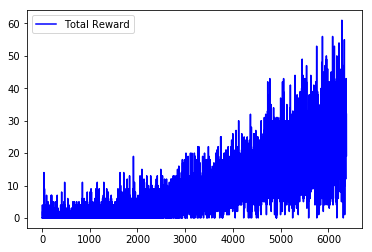

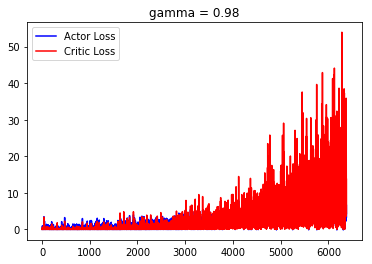

In [34]:
plt.clf()
plt.plot(total_reward, 'b-', label='Total Reward')
#plt.axhline(y=NUM_EVENTS*(0.983), color='r', linestyle='-', label='Minimum \nPefect Score')
plt.legend(loc=0)
plt.savefig(figpath+'{}_reward.svg'.format(mazetype), format = 'svg')
plt.show()

plt.clf()
plt.plot(total_loss[0], 'b', label = 'Actor Loss')
plt.title('gamma = {}'.format(discount_factor))
plt.plot(total_loss[1], 'r', label= 'Critic Loss')
plt.legend(loc=0)
plt.savefig(figpath+'{}_loss.svg'.format(mazetype), format = 'svg')
plt.show()

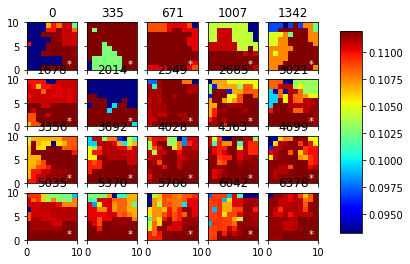

0.315152555704
6379


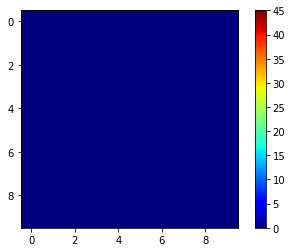

In [35]:
plotrows = 4
plotcols = 5
fig, axes = plt.subplots(nrows=plotrows, ncols=plotcols, sharex=True, sharey =True)
items = np.linspace(0, len(val_maps)-1, plotrows*plotcols)

for i, ax in enumerate(axes.flat):
    data = val_maps[int(items[i])]
    im = ax.pcolor(data, cmap= 'jet', vmin=np.nanmin(data), vmax=np.nanmax(data))
    im.cmap.set_under('white')
    ax.invert_yaxis()
    ax.annotate('*', np.add(maze.rwd_loc, (-0, .5)), color='w')
    ax.set_title('{}'.format(int(items[i])))


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
if mazetype == 'none':
    plt.savefig('./figures/grid_obs{}_valuemap.svg'.format(obs_rho), format='svg')
else: 
    plt.savefig('./figures/{}_valuemap.svg'.format(mazetype), format='svg')
plt.show()

print np.nanmax(val_maps)

data = val_maps[-1]
print len(val_maps)
plt.imshow(data, vmin=0, vmax=45, cmap='jet', interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
data = val_maps[-1].copy()
data[np.where(data>0)] = 0

## Plot actual choice
fig = plt.figure()

cmap = plt.cm.Spectral_r
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap=cmap)


ax1  = fig.add_axes([0.04, 0, 0.4, 0.85]) # [left, bottom, width, height]
ax2   = fig.add_axes([0.47, 0, 0.4, 0.85]) # [left, bottom, width, height]
axc = fig.add_axes([0.89, 0.125, 0.05, 0.6])

cb1 = mpl.colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)

ax1.imshow(data, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax1.add_patch(patches.Circle(maze.rwd_loc, 0.35, fc='w'))

ax2.imshow(data, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax2.add_patch(patches.Circle(maze.rwd_loc, 0.35, fc='w'))


# p_field indicies
# 0 - choice, 
# 1 - list(tfprob)[choice], 
# 2 - list(tfprob).index(max(list(tfprob))), 
# 3 - max(list(tfprob)), 
# 4 - i)

for i in range(0, p_field.shape[0]):
    for j in range(0, p_field.shape[1]):
        dx1, dy1, head_w1, head_l1 = make_arrows(p_field[i][j][0], p_field[i][j][1]) 
        if (dx1, dy1) == (0,0):
            pass
        else:
            colorVal1 = scalarMap.to_rgba(p_field[i][j][1])
            ax1.arrow(j, i, dx1, dy1, head_width =0.3, head_length =0.2, color=colorVal1, alpha = 1 - ((len(val_maps)-p_field[i][j][4])/len(val_maps)))
            
        dx2, dy2, head_w2, head_l2 = make_arrows(p_field[i][j][2], p_field[i][j][3])
        if (dx2, dy2) == (0,0):
            pass
        else:
            colorVal2 = scalarMap.to_rgba(p_field[i][j][1])
            ax2.arrow(j, i, dx2, dy2, head_width =0.3, head_length =0.2, color=colorVal2, alpha = 1 - ((len(val_maps)-p_field[i][j][4])/len(val_maps)))
            
ax1.set_title("Chosen Action")
ax2.set_title("Most likely choice")
plt.savefig('./figures/{}choice_field.svg'.format(mazetype),format ='svg')
plt.show()
